0. Import packages and modeling parameters

In [2]:
import pandas as pd
from dataretrieval import nwis
import numpy as np
import os
os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import math
from datetime import datetime
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
              "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365
print( "missing_data_threshold:", missing_data_threshold)

Current time: 2025-03-30 16:29:55.176063
missing_data_threshold: 328.5


1. Get site info and data

In [4]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
print( dailyStreamtemp_df)

site_info_df:   agency_cd   site_no                              station_nm site_tp_cd  \
0      USGS  13296000  YANKEE FORK SALMON RIVER NR CLAYTON ID         ST   

   lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  ...  \
0  441632  1144404   44.278889  -114.733889             N             1  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                     geometry  
0           NaN          NaN         NaN  POINT (-114.73389 44.27889)  

[1 rows x 43 columns]
station_nm: YANKEE FORK SALMON RIVER NR CLAYTON ID
                      datetime   site_no  00010_Maximum 00010_Maximum_cd  \
0    2011-10-01 00:00:00+00:00  13296000            NaN              NaN   
1    2011-10-02 00:00:00+00:00  13296000            NaN              NaN   
2    2011-10-03 00:00:00+00:00  13296000            NaN        

2. get prism data  

In [6]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date
print( prism_df.dtypes )
print(  prism_df["site_no"].unique()  )



             date      tmean   site_no  Days_Since_October_1st     rad_d
0      1995-01-01 -18.306002  06038800                      92  1.583707
1      1995-01-02 -17.829000  06038800                      93  1.600921
2      1995-01-03 -18.317001  06038800                      94  1.618135
3      1995-01-04 -15.904000  06038800                      95  1.635350
4      1995-01-05 -11.903001  06038800                      96  1.652564
...           ...        ...       ...                     ...       ...
282875 2024-10-10  14.149199  13342500                       9  0.154928
282876 2024-10-11  13.611249  13342500                      10  0.172142
282877 2024-10-12  16.385151  13342500                      11  0.189356
282878 2024-10-13  14.676150  13342500                      12  0.206570
282879 2024-10-14  16.204950  13342500                      13  0.223785

[282880 rows x 5 columns]
date                      datetime64[ns]
tmean                            float64
site_no        

3. merge prism and usgs

In [8]:
#print(prism_df['date'])
#print(prism_df['Date'])
#print(dailyStreamtemp_df['Date'])

prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
print(result)
#print(result.columns)

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
0     12.825001  13296000  2011-10-01  0.000000         NaN        68.0   
1     11.882001  13296000  2011-10-02  0.017214         NaN        68.0   
2     11.608001  13296000  2011-10-03  0.034428         NaN        64.0   
3      5.718000  13296000  2011-10-04  0.051643         NaN        68.0   
4      1.404000  13296000  2011-10-05  0.068857         7.6       101.0   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  
0        10  2011  
1        10  2011  
2        10  2011  
3        10  2011  

4. rm NANs

In [10]:
# Count the number of NaN values in each column
na_count = result.isna().sum()

# Print the result
#print(na_count)

# Drop rows with any NaN values
df_cleaned = result.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

# Print the result
print(na_count)

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4      1.404000  13296000  2011-10-05  0.068857         7.6       101.0   
5      0.116000  13296000  2011-10-06  0.086071         5.7       110.0   
6      1.584000  13296000  2011-10-07  0.103285         6.0        94.0   
7      3.003000  13296000  2011-10-08  0.120499         6.4        90.3   
8      3.881000  13296000  2011-10-09  0.137714         5.5        85.9   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  
4        10  2011  
5        10  2011  
6        10  2011  
7        10  2011  

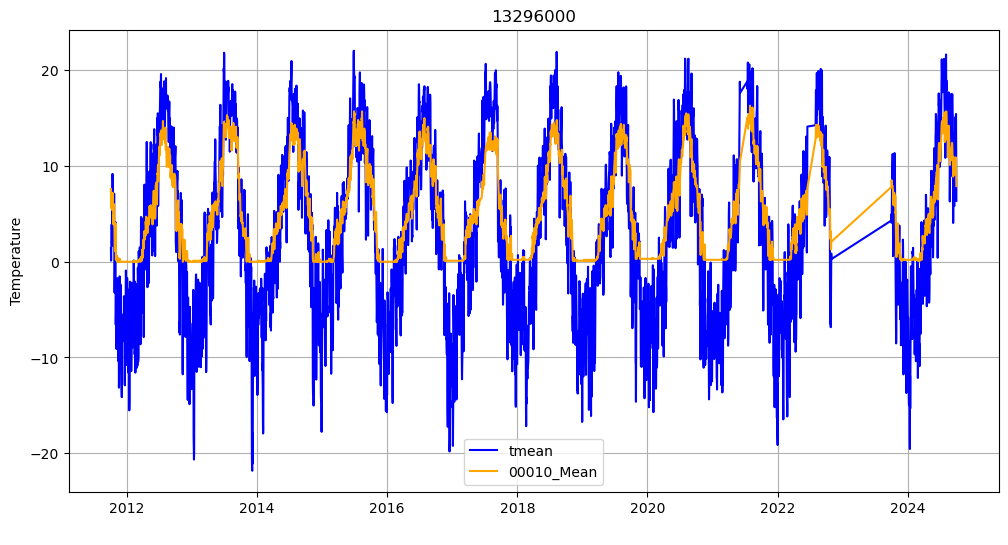

In [11]:
#import matplotlib.pyplot as plt

# Ensure 'Date' column is in datetime format
#df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Plot the two lines
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Date'], df_cleaned['tmean'], label='tmean', color='blue')
plt.plot(df_cleaned['Date'], df_cleaned['00010_Mean'], label='00010_Mean', color='orange')

# Add labels, title, and legend
plt.xlabel(' ')
plt.ylabel('Temperature')
plt.title( model_site[0] )
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


       tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  Month  \
4224  4.3011  13296000  2023-10-01  0.000000         7.8        74.9     10   
4225  4.9851  13296000  2023-10-02  0.017214         8.5        78.6     10   
4226  4.0587  13296000  2023-10-03  0.034428         8.4        78.9     10   
4227  6.2417  13296000  2023-10-04  0.051643         8.4        76.9     10   
4228  7.9720  13296000  2023-10-05  0.068857         7.9        72.9     10   
...      ...       ...         ...       ...         ...         ...    ...   
4311 -5.9902  13296000  2023-12-27  1.497636         0.2        52.0     12   
4312 -2.3123  13296000  2023-12-28  1.514850         0.2        53.5     12   
4313 -1.8780  13296000  2023-12-29  1.532064         0.2        54.5     12   
4314 -3.2800  13296000  2023-12-30  1.549279         0.2        53.5     12   
4315 -4.7788  13296000  2023-12-31  1.566493         0.2        52.1     12   

      Year  
4224  2023  
4225  2023  
4226  2023  

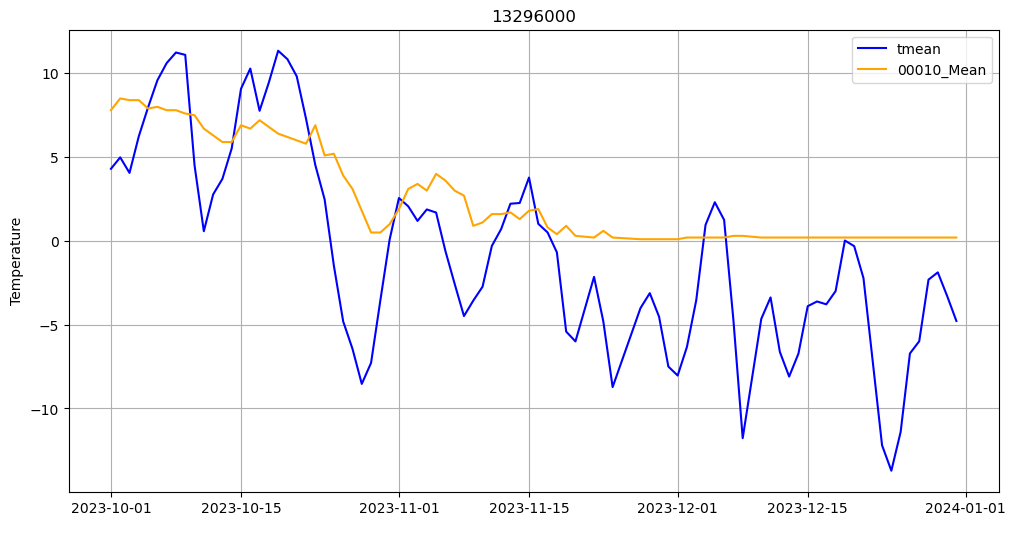

In [12]:
df_cleaned_2023 = df_cleaned[ df_cleaned["Year"]==2023 ]
print( df_cleaned_2023 )

print(df_cleaned_2023.shape)

df_yr = df_cleaned_2023

plt.figure(figsize=(12, 6))
plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='orange')


plt.xlabel(' ')
plt.ylabel('Temperature')
plt.title( model_site[0] )
plt.legend()
plt.grid(True)


plt.show()

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4316  -5.895000  13296000  2024-01-01  1.566493         0.2        50.4   
4317  -7.007500  13296000  2024-01-02  1.583707         0.2        49.2   
4318  -5.808600  13296000  2024-01-03  1.600921         0.2        51.8   
4319  -6.352200  13296000  2024-01-04  1.618135         0.2        57.3   
4320  -9.115700  13296000  2024-01-05  1.635350         0.2        58.5   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  
4316      1  2024  
4317      1  2024  
4318      1  2024  
4319      1  2024  

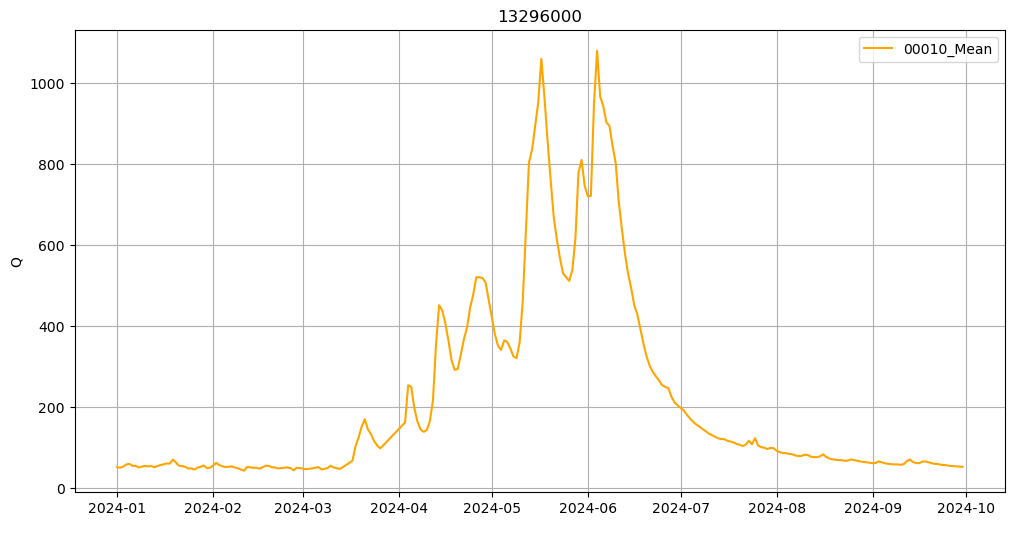

In [13]:
df_cleaned_2024 = df_cleaned[ df_cleaned["Year"]==2024 ]
print( df_cleaned_2024 )

print(df_cleaned_2024.shape)

df_yr = df_cleaned_2024

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00060_Mean'], label='00010_Mean', color='orange')


plt.xlabel(' ')
plt.ylabel('Q')
plt.title( model_site[0] )
plt.legend()
plt.grid(True)


plt.show()

In [14]:
def get_water_year(date):
        if date.month >= 10: 
            #print(date)
            return date.year +1
            #print(date.year+1)
        else:   
            return date.year



df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)

print(df_cleaned)

print(df_cleaned['water_year'].unique())



          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4      1.404000  13296000  2011-10-05  0.068857         7.6       101.0   
5      0.116000  13296000  2011-10-06  0.086071         5.7       110.0   
6      1.584000  13296000  2011-10-07  0.103285         6.0        94.0   
7      3.003000  13296000  2011-10-08  0.120499         6.4        90.3   
8      3.881000  13296000  2011-10-09  0.137714         5.5        85.9   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  water_year  
4        10  2011        2012  
5        10  2011        2012  
6  

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\988185059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4018   4.971300  13296000  2022-10-01  0.000000         7.5        69.3   
4019   5.455400  13296000  2022-10-02  0.017214         7.9        69.9   
4020   8.877600  13296000  2022-10-03  0.034428         8.4        69.6   
4021   9.916900  13296000  2022-10-04  0.051643         8.2        67.7   
4022  11.071099  13296000  2022-10-05  0.068857         8.0        66.5   
4023  11.630000  13296000  2022-10-06  0.086071         7.9        65.2   
4024  11.335999  13296000  2022-10-07  0.103285         7.8        64.2   
4025  10.390600  13296000  2022-10-08  0.120499         7.7        63.6   
4026   9.858500  13296000  2022-10-09  0.137714         7.3        63.0   
4027   8.603400  13296000  2022-10-10  0.154928         6.8        62.7   
4028   8.042500  13296000  2022-10-11  0.172142         7.1        62.4   
4029   8.618899  13296000  2022-10-12  0.189356         6.5        61.6   
4030  10.089600  13296000

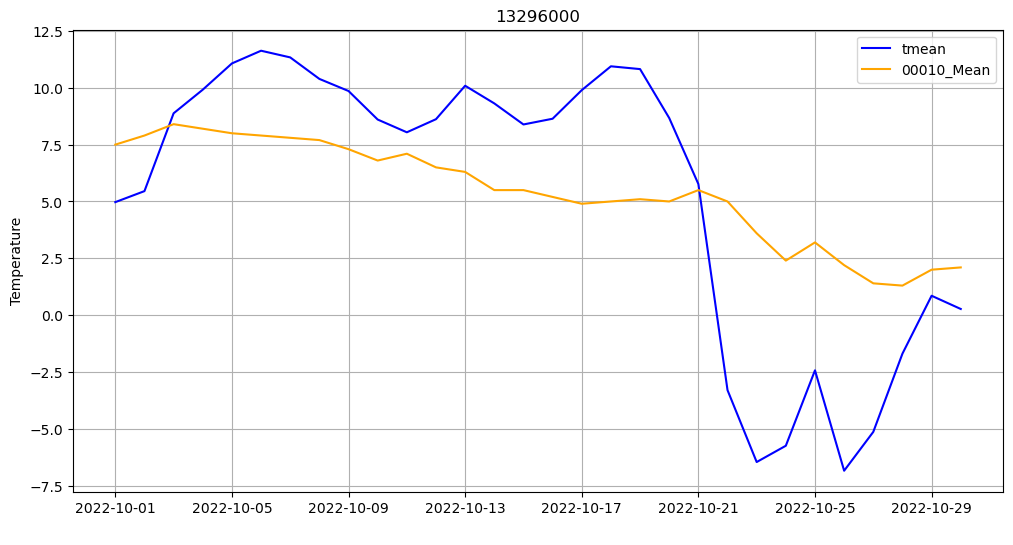

In [15]:
df_cleaned_2023 = df_cleaned[ df_cleaned["water_year"]==2023 ]
print( df_cleaned_2023 )

print(df_cleaned_2023.shape)

df_yr = df_cleaned_2023

plt.figure(figsize=(12, 6))
plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='orange')


plt.xlabel(' ')
plt.ylabel('Temperature')
plt.title( model_site[0] )
plt.legend()
plt.grid(True)


plt.show()

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
2557   6.393000  13296000  2018-10-01  0.000000         6.8        69.2   
2558  10.944000  13296000  2018-10-02  0.017214         8.3        69.6   
2559   8.479000  13296000  2018-10-03  0.034428         8.7        69.7   
2560   2.220000  13296000  2018-10-04  0.051643         7.4        76.5   
2561   1.689000  13296000  2018-10-05  0.068857         6.6        80.0   
...         ...       ...         ...       ...         ...         ...   
2917   9.038899  13296000  2019-09-26  6.197114         9.0        63.0   
2918   5.766900  13296000  2019-09-27  6.214328         9.6        63.9   
2919   1.805900  13296000  2019-09-28  6.231543         6.8        63.5   
2920  -3.400000  13296000  2019-09-29  6.248757         5.9        67.5   
2921  -3.658500  13296000  2019-09-30  6.265971         4.6        65.0   

      Month  Year  water_year  
2557     10  2018        2019  
2558     10  2018        2019  
255

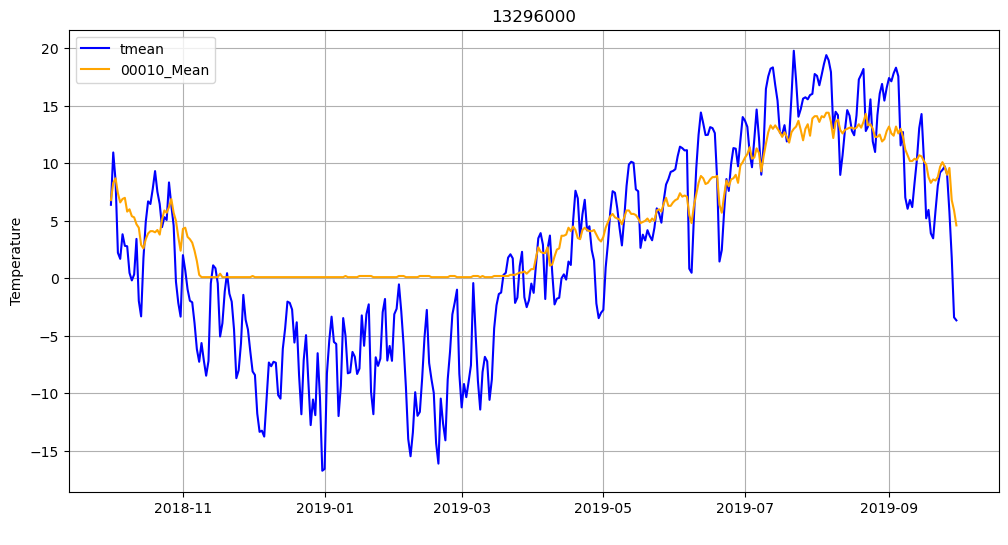

In [16]:
df_cleaned_2019 = df_cleaned[ df_cleaned["water_year"]== 2019 ]
print( df_cleaned_2019 )
#print(df_cleaned_2019.shape)
df_yr = df_cleaned_2019

plt.figure(figsize=(12, 6))
plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='orange')

plt.xlabel(' ')
plt.ylabel('Temperature')
plt.title( model_site[0] )
plt.legend()
plt.grid(True)

plt.show()

        tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  Month  \
3506   2.6683  13296000  2021-05-07  3.752697         5.8       582.0      5   
3507  -0.8910  13296000  2021-05-08  3.769911         4.8       551.0      5   
3508  -0.9442  13296000  2021-05-09  3.787125         4.1       492.0      5   
3509  -0.0996  13296000  2021-05-10  3.804340         4.0       443.0      5   
3510   2.8770  13296000  2021-05-11  3.821554         5.1       402.0      5   
...       ...       ...         ...       ...         ...         ...    ...   
3648  13.6402  13296000  2021-09-26  6.197114         9.6        46.3      9   
3649  12.1402  13296000  2021-09-27  6.214328         8.9        45.7      9   
3650   1.7421  13296000  2021-09-28  6.231543         7.5        45.7      9   
3651   2.5561  13296000  2021-09-29  6.248757         6.3        46.2      9   
3652   6.1847  13296000  2021-09-30  6.265971         6.4        46.2      9   

      Year  water_year  7_day_avg_tmean

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\2650714764.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\2650714764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()


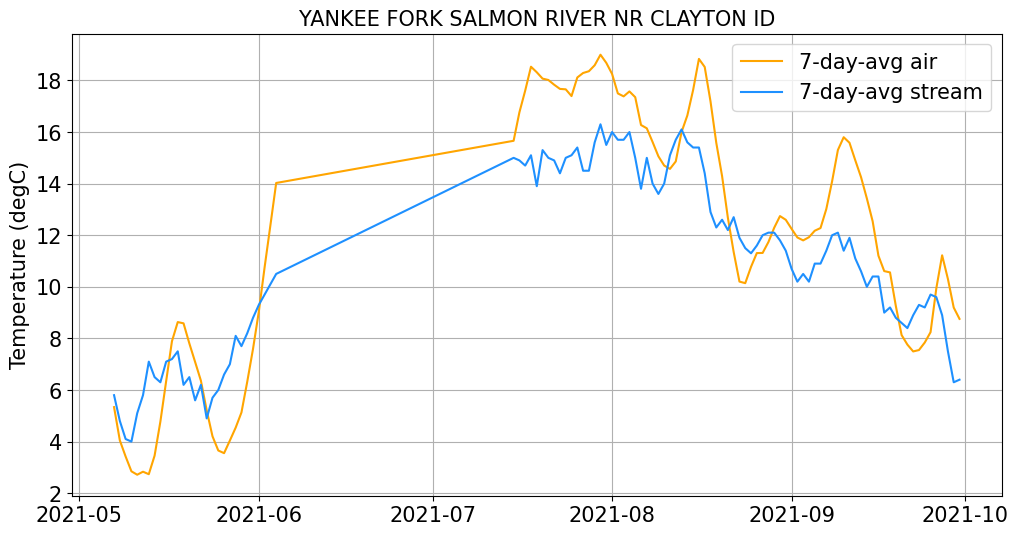

In [17]:
fontsize = 15

df_cleaned_2021 = df_cleaned[ (df_cleaned["water_year"]== 2021 )
& (df_cleaned["Month"].isin(range( 5,9+1)) )
]

df_yr = df_cleaned_2021

# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='red')
plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')
#plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='7-day-avg stream', color='dodgerblue')

plt.xlabel(' ')
plt.ylabel('Temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
plt.legend( fontsize = fontsize )
plt.grid(True)
plt.savefig("7_day_avg_plot.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\185917581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\185917581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()


          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
2806   0.834000  13296000  2019-06-07  4.286337         5.5      1290.0   
2807   0.481500  13296000  2019-06-08  4.303552         4.8      1040.0   
2808   5.334500  13296000  2019-06-09  4.320766         6.3       852.0   
2809   9.538899  13296000  2019-06-10  4.337980         7.3       749.0   
2810  12.480000  13296000  2019-06-11  4.355194         8.3       731.0   
...         ...       ...         ...       ...         ...         ...   
2887  14.181499  13296000  2019-08-27  5.680688        12.3        72.5   
2888  16.058500  13296000  2019-08-28  5.697902        12.5        70.6   
2889  16.906000  13296000  2019-08-29  5.715116        11.9        69.4   
2890  15.455400  13296000  2019-08-30  5.732331        12.1        70.0   
2891  16.571499  13296000  2019-08-31  5.749545        12.8        69.8   

      Month  Year  water_year  7_day_avg_tmean  7_day_avg_00010_Mean  
2806      6  2019        201

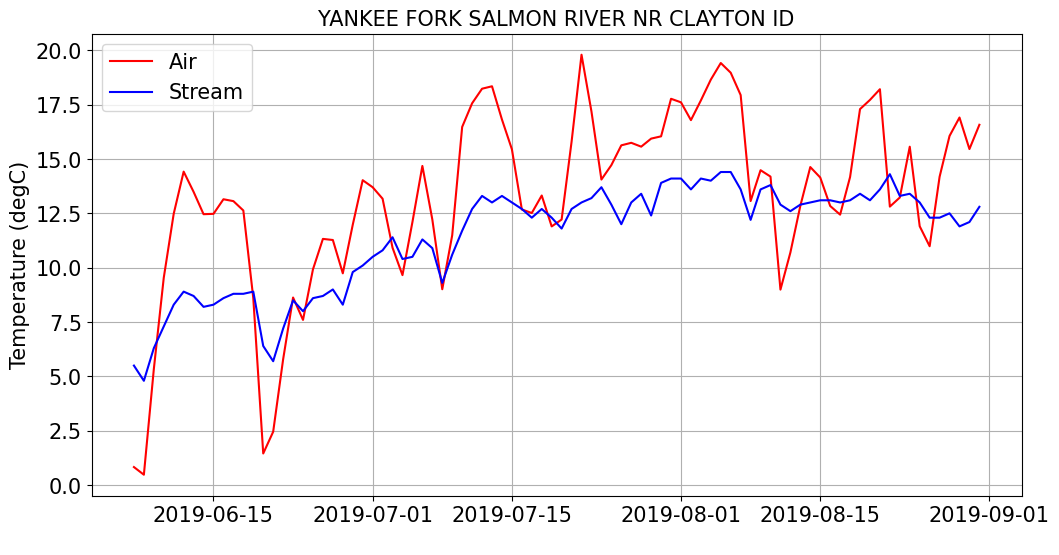

In [18]:
fontsize = 15

df_cleaned_2019 = df_cleaned[ (df_cleaned["water_year"]== 2019 )
& (df_cleaned["Month"].isin(range( 6, 8+1)) )
]

df_yr = df_cleaned_2019

# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
plt.plot( df_yr['Date'],  df_yr['tmean'], label='Air', color='red')
#plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='Stream', color='blue')
#plt.plot( df_yr['Date'], df_yr['7_day_avg_00010_Mean'], label='7-day-avg stream', color='dodgerblue')

plt.xlabel(' ')
plt.ylabel('Temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
plt.legend( fontsize = fontsize )
plt.grid(True)
plt.savefig("7_day_avg_plot_2019.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\1104243472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\1104243472.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()


          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
1688   4.647000  13296000  2016-05-15  3.890411         5.9      1080.0   
1689   4.737000  13296000  2016-05-16  3.907625         5.4      1040.0   
1690   7.656000  13296000  2016-05-17  3.924839         6.3       959.0   
1691   9.416000  13296000  2016-05-18  3.942053         6.9       976.0   
1692   3.879000  13296000  2016-05-19  3.959267         5.9      1090.0   
...         ...       ...         ...       ...         ...         ...   
1822  13.050000  13296000  2016-09-26  6.197114         9.3        63.6   
1823  13.726001  13296000  2016-09-27  6.214328         9.5        62.1   
1824  13.771001  13296000  2016-09-28  6.231543         9.6        61.2   
1825  12.802001  13296000  2016-09-29  6.248757         9.6        60.2   
1826  11.417001  13296000  2016-09-30  6.265971        10.0        60.9   

      Month  Year  water_year  7_day_avg_tmean  7_day_avg_00010_Mean  
1688      5  2016        201

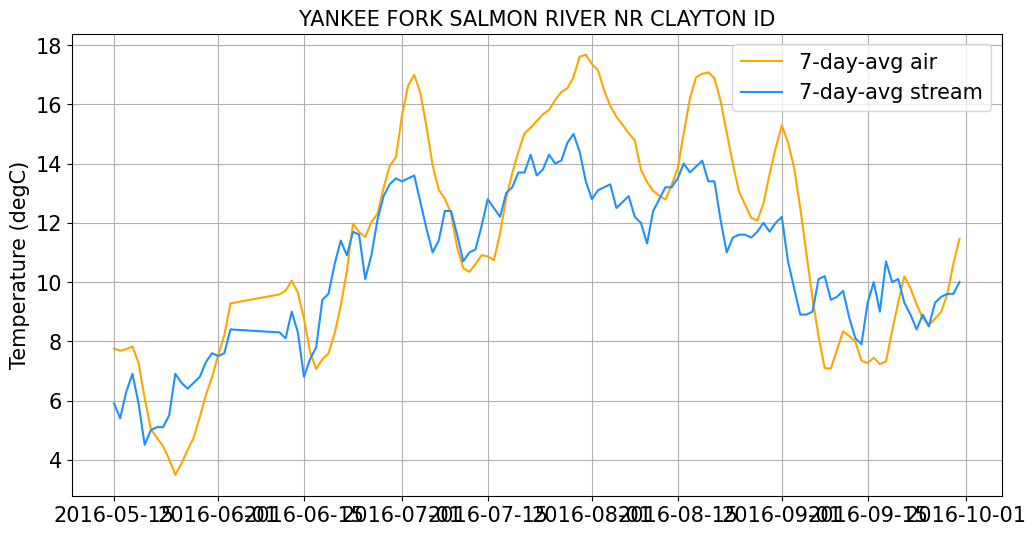

In [19]:
fontsize = 15
fig = "7_day_avg_plot_2016.png"
df_cleaned_2016 = df_cleaned[ (df_cleaned["water_year"]== 2016 )
& (df_cleaned["Month"].isin(range( 5,9+1)) )
]

df_yr = df_cleaned_2016

# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='red')
plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')
#plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='7-day-avg stream', color='dodgerblue')

plt.xlabel(' ')
plt.ylabel('Temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
plt.legend( fontsize = fontsize )
plt.grid(True)
plt.savefig( fig, dpi=300, bbox_inches='tight')
plt.show()

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\3525439636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['Date'] = pd.to_datetime(df_yr['Date'], format='%Y-%m-%d')
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\3525439636.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\3525439636.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

        tmean   site_no       Date     rad_d  00010_Mean  00060_Mean  Month  \
2563   2.8240  13296000 2018-10-07  0.103285         7.0        74.1     10   
2564   2.7840  13296000 2018-10-08  0.120499         5.8        70.8     10   
2565   0.4700  13296000 2018-10-09  0.137714         6.0        78.2     10   
2566  -0.1840  13296000 2018-10-10  0.154928         5.4        77.6     10   
2567   0.3330  13296000 2018-10-11  0.172142         5.3        72.4     10   
...       ...       ...        ...       ...         ...         ...    ...   
3648  13.6402  13296000 2021-09-26  6.197114         9.6        46.3      9   
3649  12.1402  13296000 2021-09-27  6.214328         8.9        45.7      9   
3650   1.7421  13296000 2021-09-28  6.231543         7.5        45.7      9   
3651   2.5561  13296000 2021-09-29  6.248757         6.3        46.2      9   
3652   6.1847  13296000 2021-09-30  6.265971         6.4        46.2      9   

      Year  water_year  7_day_avg_tmean  7_day_avg_

IndexError: index 0 is out of bounds for axis 0 with size 0

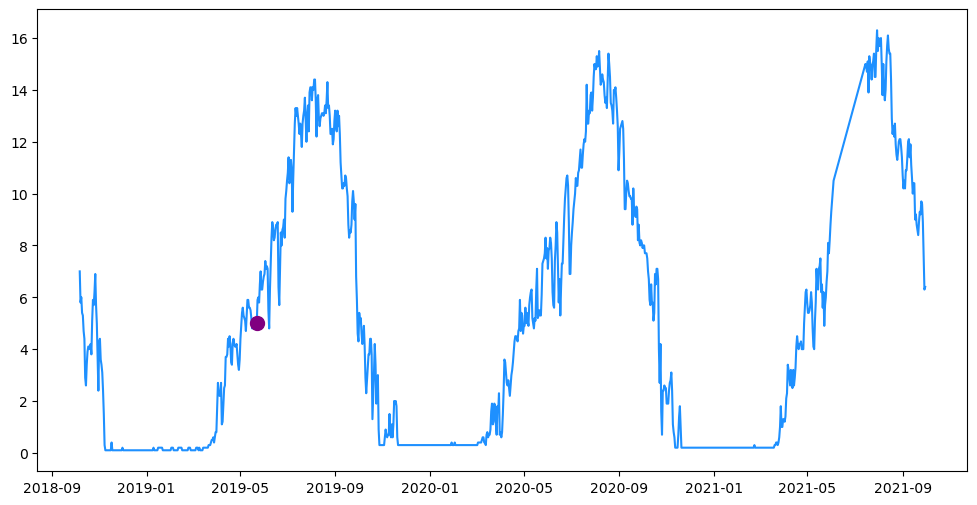

In [20]:
fontsize = 15
fig = "2019_2021.png"
df_cleaned_2019_2021 = df_cleaned[ df_cleaned["water_year"].isin(range( 2019,2021+1) )        
]

df_yr = df_cleaned_2019_2021

df_yr['Date'] = pd.to_datetime(df_yr['Date'], format='%Y-%m-%d')


# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='red')
#plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')
#plt.plot( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='blue')
plt.plot( df_yr['Date'], df_yr['00010_Mean']
         #, label='7-day-avg stream'
         , color='dodgerblue')

# 2019/5/23
#plt.axvline(pd.Timestamp('2019/5/23'), color='orange', linestyle='--', linewidth=2, label='May 2019 assessment')
# 2021/6/11
# Add vertical line at '2021-06-11'
#plt.axvline(pd.Timestamp('2021-06-11'), color='orange', linestyle='--', linewidth=2, label='June 2021 assessment')

marker_date = pd.Timestamp('2019/5/23')
marker_y = df_yr.loc[df_yr['Date'] == marker_date, '00010_Mean'].values[0]
plt.scatter(marker_date, marker_y, color='purple', s=100, label='May 2019 assessment', zorder=3)

marker_date = pd.Timestamp('2021-06-11')
marker_y = df_yr.loc[df_yr['Date'] == marker_date, '00010_Mean'].values[0]
plt.scatter(marker_date, marker_y, color='orange', s=100, label='June 2021 assessment', zorder=3)


plt.xlabel(' ')
plt.ylabel('Stream temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
plt.legend(loc='lower center', fontsize = fontsize )
plt.grid(True)
plt.savefig( fig, dpi=300, bbox_inches='tight')
plt.show()

          tmean   site_no       Date     rad_d  00010_Mean  00060_Mean  Month  \
10     1.891000  13296000 2011-10-11  0.172142         5.9       109.0     10   
11     3.286000  13296000 2011-10-12  0.189356         5.4       107.0     10   
12     5.864000  13296000 2011-10-13  0.206570         5.4        95.5     10   
13     9.173000  13296000 2011-10-14  0.223785         7.2        90.7     10   
14     8.273001  13296000 2011-10-15  0.240999         6.9        89.9     10   
...         ...       ...        ...       ...         ...         ...    ...   
4585  13.100349  13296000 2024-09-26  6.197114        10.9        53.5      9   
4586  13.638500  13296000 2024-09-27  6.214328        10.0        53.0      9   
4587  15.431150  13296000 2024-09-28  6.231543         9.8        52.6      9   
4588  10.443299  13296000 2024-09-29  6.248757         9.3        51.8      9   
4589   6.348950  13296000 2024-09-30  6.265971         7.9        51.4      9   

      Year  water_year  7_d

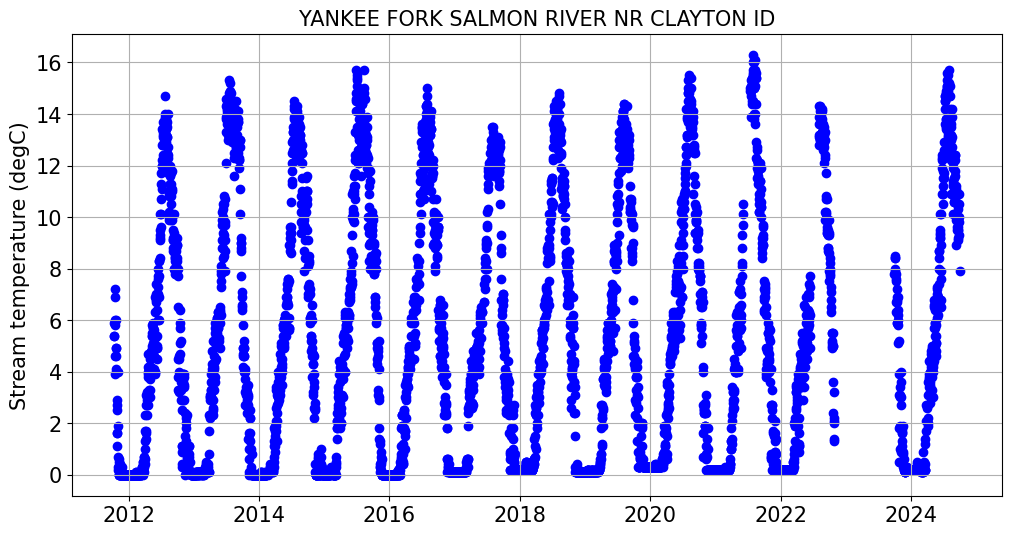

In [23]:
fontsize = 15
fig = "all.png"
#df_cleaned_2019_2021 = df_cleaned[ df_cleaned["water_year"].isin(range( 2019,2021+1) )        
#]

df_yr = df_cleaned 
df_yr = df_yr.dropna()

df_yr['Date'] = pd.to_datetime(df_yr['Date'], format='%Y-%m-%d')


# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='red')
#plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')
plt.scatter( df_yr['Date'], df_yr['00010_Mean'], label='00010_Mean', color='blue')
#plt.plot( df_yr['Date'], df_yr['00010_Mean']         , color='dodgerblue')

plt.xlabel(' ')
plt.ylabel('Stream temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
#plt.legend(loc='lower center', fontsize = fontsize )
plt.grid(True)
plt.savefig( fig, dpi=300, bbox_inches='tight')
plt.show()

          tmean   site_no       Date     rad_d  00010_Mean  00060_Mean  Month  \
2563   2.824000  13296000 2018-10-07  0.103285         7.0        74.1     10   
2564   2.784000  13296000 2018-10-08  0.120499         5.8        70.8     10   
2565   0.470000  13296000 2018-10-09  0.137714         6.0        78.2     10   
2566  -0.184000  13296000 2018-10-10  0.154928         5.4        77.6     10   
2567   0.333000  13296000 2018-10-11  0.172142         5.3        72.4     10   
...         ...       ...        ...       ...         ...         ...    ...   
4585  13.100349  13296000 2024-09-26  6.197114        10.9        53.5      9   
4586  13.638500  13296000 2024-09-27  6.214328        10.0        53.0      9   
4587  15.431150  13296000 2024-09-28  6.231543         9.8        52.6      9   
4588  10.443299  13296000 2024-09-29  6.248757         9.3        51.8      9   
4589   6.348950  13296000 2024-09-30  6.265971         7.9        51.4      9   

      Year  water_year  7_d

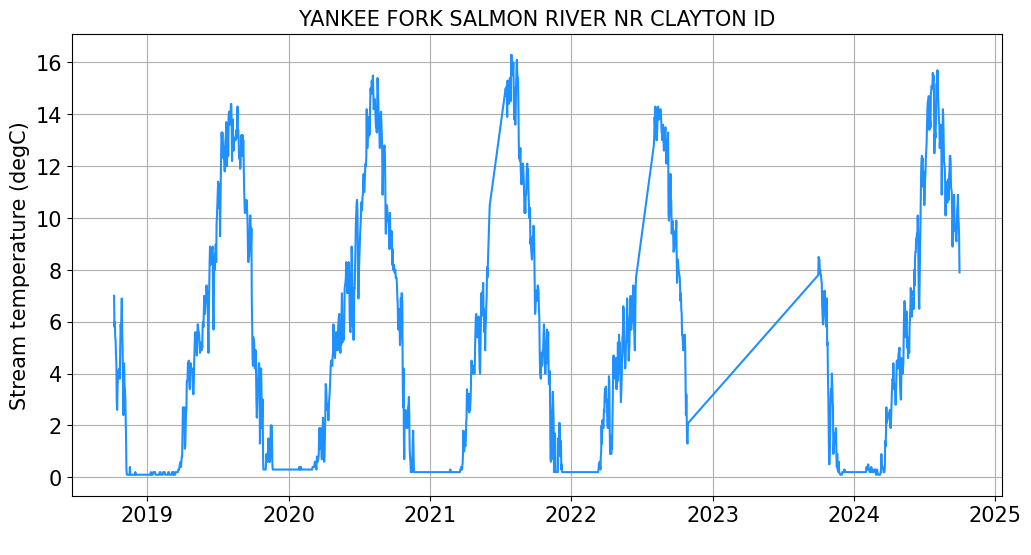

In [25]:
fontsize = 15
fig = "since_2019.png"
df_cleaned_since_2019 = df_cleaned[ df_cleaned["water_year"].isin(range( 2019,2024+1) )        ]

df_yr = df_cleaned_since_2019 
df_yr = df_yr.dropna()

df_yr['Date'] = pd.to_datetime(df_yr['Date'], format='%Y-%m-%d')


# Compute 7-day moving average
df_yr['7_day_avg_tmean'] = df_yr['tmean'].rolling(window=7).mean()
df_yr['7_day_avg_00010_Mean'] = df_yr['00010_Mean'].rolling(window=7).mean()
df_yr = df_yr.dropna()
print(df_yr)

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='red')
#plt.plot( df_yr['Date'],  df_yr['7_day_avg_tmean'], label='7-day-avg air', color='orange')

plt.plot( df_yr['Date'], df_yr['00010_Mean']         , color='dodgerblue')

plt.xlabel(' ')
plt.ylabel('Stream temperature (degC)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

plt.title( site_info_df['station_nm'][0] , fontsize = fontsize #model_site[0] 
         )
#plt.legend(loc='lower center', fontsize = fontsize )
plt.grid(True)
plt.savefig( fig, dpi=300, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4224   4.301100  13296000  2023-10-01  0.000000         7.8        74.9   
4225   4.985100  13296000  2023-10-02  0.017214         8.5        78.6   
4226   4.058700  13296000  2023-10-03  0.034428         8.4        78.9   
4227   6.241700  13296000  2023-10-04  0.051643         8.4        76.9   
4228   7.972000  13296000  2023-10-05  0.068857         7.9        72.9   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  water_year  
4224     10  2023        2024  
4225     10  2023        2024  
422

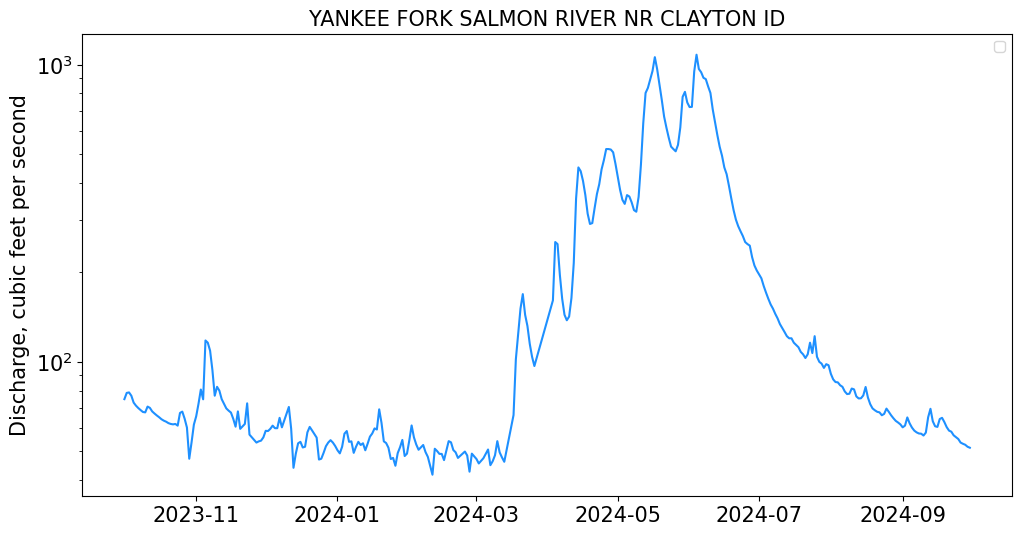

In [27]:
fontsize = 15

df_cleaned_2024 = df_cleaned[ df_cleaned["water_year"]==2024 ]
print( df_cleaned_2024 )
print(site_info_df['station_nm'][0])

print(df_cleaned_2024.shape)

df_yr = df_cleaned_2024

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00060_Mean']
         #, label=' '
         , color='dodgerblue')
# Set logarithmic scale on y-axis
plt.yscale('log')
plt.xticks( fontsize = fontsize)
plt.yticks( fontsize = fontsize)
plt.xlabel(' ')
plt.ylabel('Discharge, cubic feet per second' , fontsize = fontsize )
plt.title(  site_info_df['station_nm'][0] , fontsize = fontsize )
plt.legend()
plt.grid(False
#    True
)

#print("wy_2024_Q_"+model_site+".png")

#print(f"wy_2024_Q_{model_site[0]}.png")

plt.savefig(
    (f"wy_2024_Q_{model_site[0]}.png" )
    
    #"wy_2024_Q.png"
    , dpi=300, bbox_inches="tight") 

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4468   9.291950  13296000  2024-06-01  4.183052         6.9       720.0   
4469   8.858299  13296000  2024-06-02  4.200266         6.9       721.0   
4470   5.825950  13296000  2024-06-03  4.217481         6.5       948.0   
4471   8.403600  13296000  2024-06-04  4.234695         6.5      1080.0   
4472  12.961599  13296000  2024-06-05  4.251909         8.0       967.0   
...         ...       ...         ...       ...         ...         ...   
4555  12.921100  13296000  2024-08-27  5.680688        11.4        66.1   
4556   8.908000  13296000  2024-08-28  5.697902        11.0        64.6   
4557  11.109550  13296000  2024-08-29  5.715116        10.6        63.3   
4558  14.562000  13296000  2024-08-30  5.732331        10.6        62.5   
4559  17.222950  13296000  2024-08-31  5.749545        11.0        61.6   

      Month  Year  water_year  
4468      6  2024        2024  
4469      6  2024        2024  
447

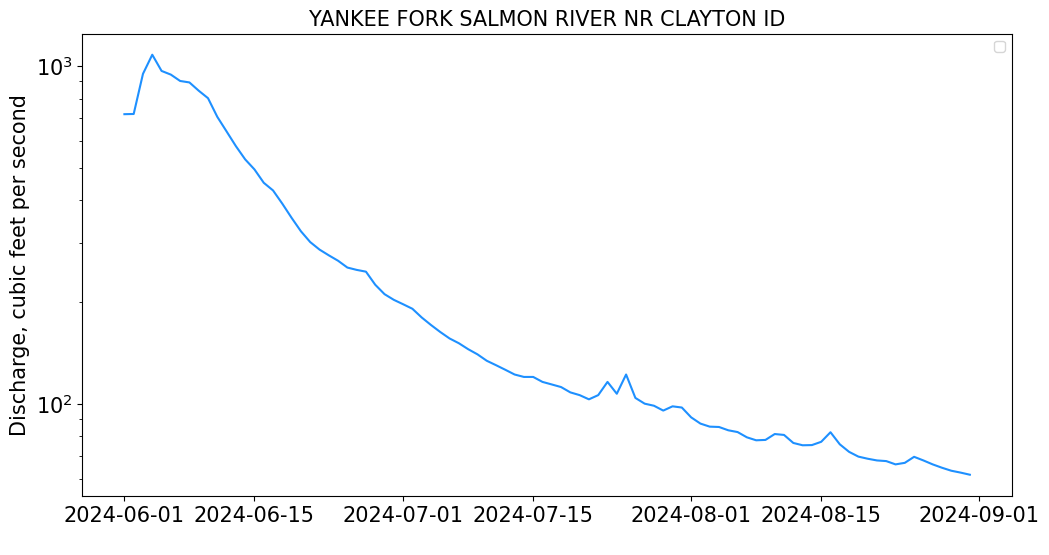

In [28]:
fontsize = 15

df_cleaned_2024 = df_cleaned[ (df_cleaned["water_year"]==2024)
& (df_cleaned["Month"].isin([6,7,8]) )]

print( df_cleaned_2024 )
print(site_info_df['station_nm'][0])

print(df_cleaned_2024.shape)

df_yr = df_cleaned_2024

plt.figure(figsize=(12, 6))
#plt.plot( df_yr['Date'],  df_yr['tmean'], label='tmean', color='blue')
plt.plot( df_yr['Date'], df_yr['00060_Mean']
         #, label=' '
         , color='dodgerblue')
# Set logarithmic scale on y-axis
plt.yscale('log')
plt.xticks( fontsize = fontsize)
plt.yticks( fontsize = fontsize)
plt.xlabel(' ')
plt.ylabel('Discharge, cubic feet per second' , fontsize = fontsize )
plt.title(  site_info_df['station_nm'][0] , fontsize = fontsize )
plt.legend()
plt.grid(False
#    True
)

#print("wy_2024_Q_"+model_site+".png")

#print(f"wy_2024_Q_{model_site[0]}.png")

plt.savefig(
    (f"wy_2024_summer_Q_{model_site[0]}.png" )
    
    #"wy_2024_Q.png"
    , dpi=300, bbox_inches="tight") 

plt.show()

In [29]:
print(df_cleaned['water_year'].value_counts())
count = pd.DataFrame(df_cleaned['water_year'].value_counts())

miss=count[ count['count']< missing_data_threshold] 
print(miss.index)
print("miss:", miss)
print(324/365)
df_cleaned = df_cleaned[ ~df_cleaned['water_year'].isin( miss.index)   ]
count = pd.DataFrame(df_cleaned['water_year'].value_counts())

water_year
2020    366
2013    365
2014    365
2015    365
2018    365
2019    365
2012    362
2016    351
2017    348
2024    345
2021    325
2022    320
2023     30
Name: count, dtype: int64
Index([2021, 2022, 2023], dtype='int64', name='water_year')
miss:             count
water_year       
2021          325
2022          320
2023           30
0.8876712328767123


In [30]:
na_counts = df_cleaned.groupby('water_year')['00010_Mean'].apply(lambda x: x.isna().sum())
print(na_counts)


water_year
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2024    0
Name: 00010_Mean, dtype: int64


calculate amp and ph

In [32]:
amp_df = pd.DataFrame({
                        "site": [ "00000000"],
                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })

for site in model_site:
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    merged_df_wy['sin_rday'] = np.sin( merged_df_wy['rad_d'] )
    merged_df_wy['cos_rday'] = np.cos( merged_df_wy['rad_d'] )
    num_rows = merged_df_wy.shape[0]
    print("Number of rows:", num_rows)
    if num_rows < missing_data_threshold:
        print("stop")
    else:    
        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  merged_df_wy ).fit()
        print("air_model:",air_model.summary())
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
        merged_df_wy['fit_air'] = air_model.predict( merged_df_wy )
        merged_df_wy['ST']=merged_df_wy['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= merged_df_wy ).fit()
        print("stream_model:",stream_model.summary())
        stream_model_coefficients = stream_model.params
        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
        print("stream_amp:", stream_amp)
        merged_df_wy['fit_stream'] = stream_model.predict( merged_df_wy )
## phase

        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
        print("ph_stream:", ph_stream)
        print("ph_air:", ph_air)
        ph_l = ph_stream - ph_air
        
##
        amp_df0 = pd.DataFrame({
                                "site": [site]
                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df=pd.concat( [amp_df,amp_df0] )

amp_df = amp_df[1:]

Number of rows: 3597
air_model:                             OLS Regression Results                            
Dep. Variable:                  tmean   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     6682.
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:33:13   Log-Likelihood:                -10273.
No. Observations:                3597   AIC:                         2.055e+04
Df Residuals:                    3594   BIC:                         2.057e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.169

C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\4278413898.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\4278413898.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
C:\Users\taohuang\AppData\Local\Temp\ipykernel_1048\4278413898.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

In [33]:
amp_df

,site,amp,ph_l
0,13296000,0.57038,5.36347


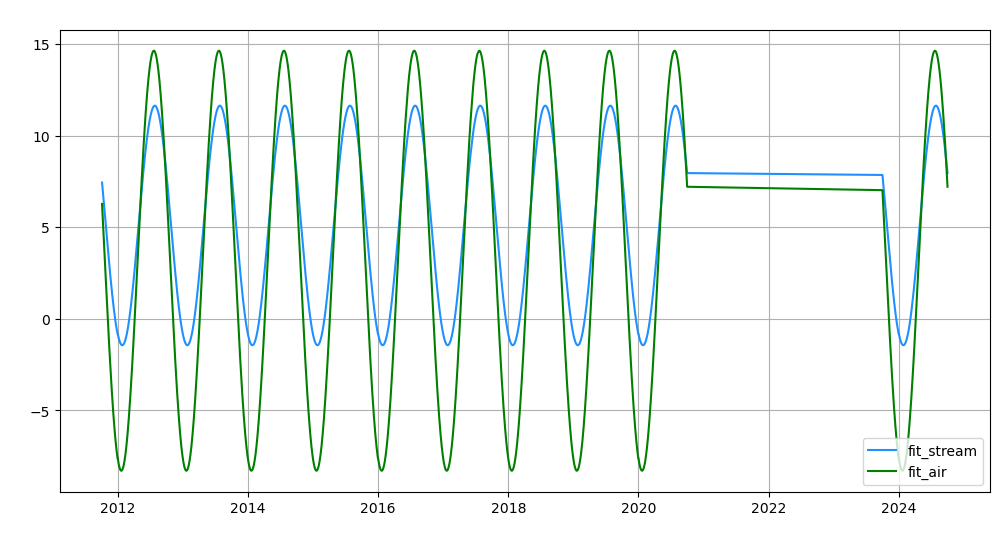

In [34]:
#import matplotlib.pyplot as plt

# Ensure 'Date' column is in datetime format
#merged_df_wy['Date'] = pd.to_datetime(merged_df_wy['Date'])

# Plot the two lines
plt.figure(figsize=(12, 6))
plt.plot(merged_df_wy['Date'], merged_df_wy['fit_stream'], label='fit_stream', color='dodgerblue')
plt.plot(merged_df_wy['Date'], merged_df_wy['fit_air'], label='fit_air', color='green')

# Add labels, title, and legend
plt.xlabel(' ')
plt.ylabel(' ')
plt.title(' ')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


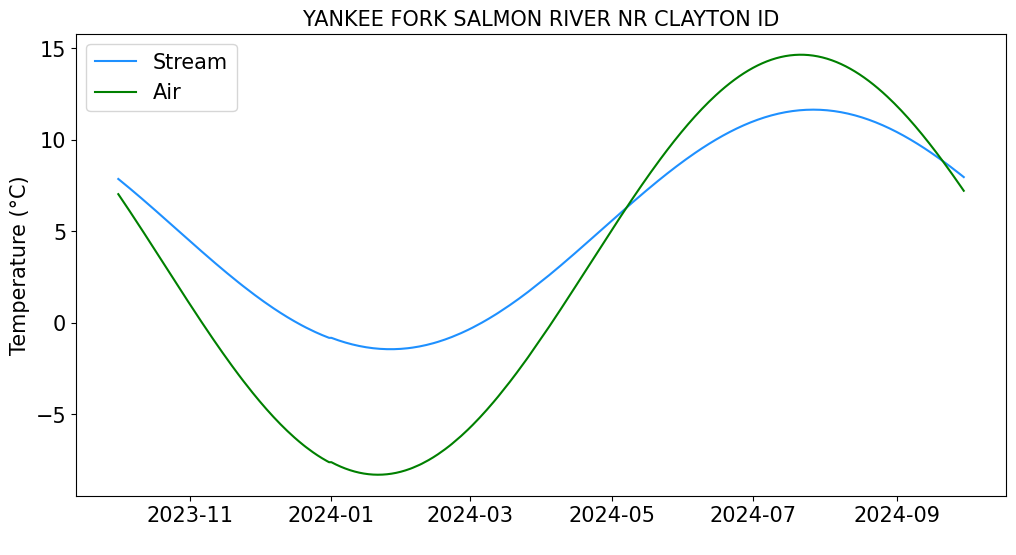

In [35]:
fontsize = 15

merged_df_wy_2024 = merged_df_wy[ merged_df_wy["water_year"] == 2024  ]
merged_df_wy_2024

plt.figure(figsize=(12, 6))
plt.plot( merged_df_wy_2024['Date'],  merged_df_wy_2024['fit_stream'], label='Stream', color='dodgerblue')
plt.plot( merged_df_wy_2024['Date'],  merged_df_wy_2024['fit_air'], label='Air', color='green')

#plt.plot( merged_df_wy_2024['Date'],  merged_df_wy_2024['tmean'], label=' ', color='red')
#plt.plot( merged_df_wy_2024['Date'],  merged_df_wy_2024['00010_Mean'], label=' ', color='orange')

# Add labels, title, and legend
plt.xlabel(' ')
plt.ylabel("Temperature (°C)",   fontsize = fontsize ) 
plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )

plt.title( site_info_df['station_nm'][0]
, fontsize = fontsize
)
plt.legend( fontsize = fontsize )
plt.grid(False)

# Save the plot locally (e.g., as a PNG file)
plt.savefig("fit_plot.png")
            
# Show the plot
plt.show()

In [41]:
print(merged_df_wy_2024.iloc[ 302])
print(merged_df_wy_2024.iloc[ 292])
# ph_stream)
       # print("ph_air

tmean          17.072849
site_no         13296000
Date          2024-08-19
rad_d           5.542974
00010_Mean          13.9
00060_Mean          69.7
Month                  8
Year                2024
water_year          2024
sin_rday       -0.674444
cos_rday        0.738326
fit_air        13.294039
ST                  13.9
fit_stream     11.128395
Name: 4547, dtype: object
tmean          16.492901
site_no         13296000
Date          2024-08-09
rad_d           5.370832
00010_Mean          13.6
00060_Mean          78.1
Month                  8
Year                2024
water_year          2024
sin_rday       -0.790946
cos_rday        0.611886
fit_air        14.064803
ST                  13.6
fit_stream     11.470775
Name: 4537, dtype: object


In [43]:
ph_stream

299.01936847001735

In [45]:
ph_air

293.6558981008979